# Fine Tune Stable Diffusion

Fine tuning Stable Diffusion on Pokemon, 
for more details see the [Lambda Labs examples repo](https://github.com/LambdaLabsML/examples). 

We recommend using a multi-GPU machine, for example an instance from [Lambda GPU Cloud](https://lambdalabs.com/service/gpu-cloud). If running on Colab this notebook is likely to need a GPU with >16GB of VRAM and a runtime with high RAM, which will almost certainly need Colab Pro or Pro+. (If you get errors suchs as `Killed` or `CUDA out of memory` then one of these is not sufficient)

In [ ]:
!git clone https://github.com/justinpinkney/stable-diffusion.git
%cd stable-diffusion
!pip install --upgrade pip
!pip install -r requirements.txt

!pip install --upgrade keras # on lambda stack we need to upgrade keras
!pip uninstall -y torchtext # on colab we need to remove torchtext

In [2]:
!nvidia-smi

Tue Mar 21 19:42:12 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.18                 Driver Version: 531.18       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti    WDDM | 00000000:01:00.0  On |                  N/A |
|  0%   41C    P8               25W / 200W|   1315MiB /  8192MiB |     35%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Using custom data configuration polytechXhf--jojos-dataset-small-ec277a7abd0a2243
Found cached dataset parquet (C:/Users/leona/.cache/huggingface/datasets/polytechXhf___parquet/polytechXhf--jojos-dataset-small-ec277a7abd0a2243/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

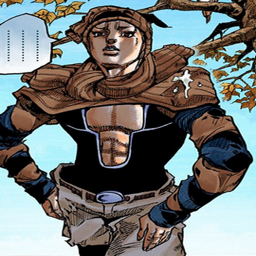

a close up of a man in a helmet and a helmet on a tree


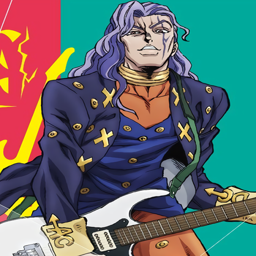

anime - style image of a man with a guitar and a guitar


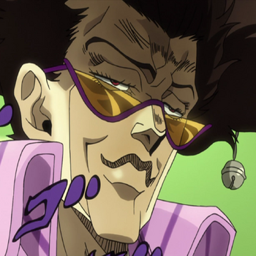

a close up of a man in a purple shirt and sunglasses
the dataset have : 50 items.


In [20]:
# Check the dataset
from datasets import load_dataset
#ds = load_dataset("lambdalabs/pokemon-blip-captions", split="train")
ds = load_dataset("polytechXhf/jojos-dataset-small")
ds = ds['train']

#show the 3 first items of the dataset :
for i in range(0, 3):
    sample = ds[i]
    display(sample["image"].resize((256, 256)))
    print(sample["text"])

print("\nthe dataset have : " + str(len(ds)) + " items.")

To get the weights you need to you'll need to [go to the model card](https://huggingface.co/CompVis/stable-diffusion-v1-4-original), read the license and tick the checkbox if you agree.

In [19]:
!pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

In [18]:
from huggingface_hub import hf_hub_download
ckpt_path = hf_hub_download(repo_id="CompVis/stable-diffusion-v-1-4-original", filename="sd-v1-4-full-ema.ckpt", use_auth_token=True)

OSError: Token is required (`token=True`), but no token found. You need to provide a token or be logged in to Hugging Face with `huggingface-cli login` or `huggingface_hub.login`. See https://huggingface.co/settings/tokens.

Set your parameters below depending on your GPU setup, the settings below were used for training on a 2xA6000 machine, (the A6000 has 48GB of VRAM). On this set up good results are achieved in around 6 hours.

You can make up for using smaller batches or fewer gpus by accumulating batches:

`total batch size = batach size * n gpus * accumulate batches`

In [ ]:
# 2xA6000:
BATCH_SIZE = 4
N_GPUS = 2
ACCUMULATE_BATCHES = 1

gpu_list = ",".join((str(x) for x in range(N_GPUS))) + ","
print(f"Using GPUs: {gpu_list}")

In [ ]:
# Run training
!(python main.py \
    -t \
    --base configs/stable-diffusion/pokemon.yaml \
    --gpus "$gpu_list" \
    --scale_lr False \
    --num_nodes 1 \
    --check_val_every_n_epoch 10 \
    --finetune_from "$ckpt_path" \
    data.params.batch_size="$BATCH_SIZE" \
    lightning.trainer.accumulate_grad_batches="$ACCUMULATE_BATCHES" \
    data.params.validation.params.n_gpus="$NUM_GPUS" \
)

In [ ]:
# Run the model
!(python scripts/txt2img.py \
    --prompt 'robotic cat with wings' \
    --outdir 'outputs/generated_pokemon' \
    --H 512 --W 512 \
    --n_samples 4 \
    --config 'configs/stable-diffusion/pokemon.yaml' \
    --ckpt 'path/to/your/checkpoint')